# Calibration results for put options
### Kirill Zakharov
2024

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.integrate import quad
from scipy.fft import fft, ifft
from scipy.interpolate import interp1d
import scipy.integrate as integrate
import scipy.stats as st
import scipy.special as sp
import enum 
import scipy.optimize as optimize
from scipy.optimize import minimize
from functools import partial
from scipy.optimize import minimize, fsolve, basinhopping, newton
import tqdm
import yfinance as yf
import yahoo_fin.options as ops
from datetime import datetime
import cmath

%matplotlib inline

plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")

In [2]:
import Functions.exact_methods as exm
import Functions.characteristics_functions as chf
import Functions.monte_carlo_methods as mcm
import Functions.stochastic_processes as stch
import Calibration_tools.Error_functions as errf
import Calibration_tools.Visualization as vis
import Calibration_tools.Heston_HW as hhw

In [3]:
import matplotlib as mpl
#set params for the article
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['axes.labelsize'] = 20

#set params for the notebook
# mpl.rcParams['xtick.labelsize'] = 12
# mpl.rcParams['ytick.labelsize'] = 12
# mpl.rcParams['legend.fontsize'] = 10
# mpl.rcParams['axes.labelsize'] = 14

Import expiration dates for stock options

In [60]:
ticker_name = 'NVDA'
expiration_dates = ops.get_expiration_dates(ticker_name)
expiration_date = expiration_dates[0]

In [61]:
expiration_dates

['\n']

If expiration_dates is empty, then use the predefined date.

In [62]:
# expiration_date = 'September 20, 2024'
expiration_date = 'June 21, 2024'

Take today's value of the stock $S_0=S(t_0)$

In [63]:
# s0_apple = 150.62 #15.03.2022
curr_price = yf.Ticker(ticker_name)
s0 = curr_price.history().iloc[-1, 3]
x0 = np.log(s0)
s0

1096.3299560546875

Download the open contracts information

In [64]:
# option_data = ops.get_puts(ticker_name, expiration_dates[3])
option_data = ops.get_calls(ticker_name, date=expiration_date)
option_data.head()

,Contract Name,Last Trade Date (EDT),Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility
0,NVDA240621C00005000,5/31/2024 7:45 PM,5.0,1094.89,1083.80,1097.45,-20.81,-1.87%,42,6633,0.00%
1,NVDA240621C00010000,5/23/2024 7:43 PM,10.0,1027.00,1078.70,1092.40,0.00,0.00%,82,175,"1,526.76%"
2,NVDA240621C00015000,5/23/2024 1:43 PM,15.0,1016.64,1073.85,1087.45,0.00,0.00%,1,36,"1,254.88%"
3,NVDA240621C00020000,5/28/2024 5:52 PM,20.0,1117.76,1068.40,1082.45,0.00,0.00%,14,137,"1,110.06%"
4,NVDA240621C00025000,5/3/2024 4:45 PM,25.0,862.05,1063.85,1077.70,0.00,0.00%,1,80,"1,025.00%"


In [67]:
option_data = option_data[(option_data['Strike']>200) & (option_data['Strike']<1600)]

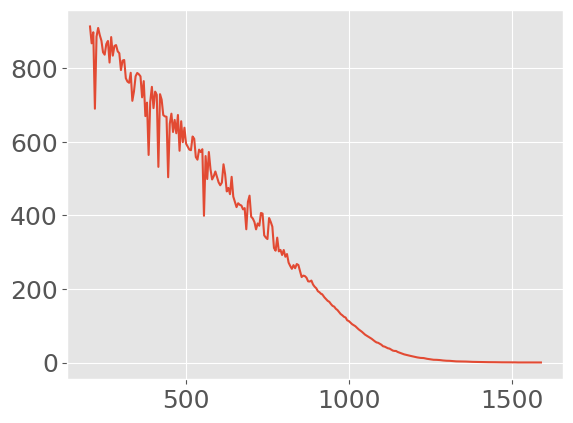

In [68]:
plt.plot(option_data['Strike'], option_data['Last Price'])
plt.show()

In [11]:
# option_data.to_csv('apple_option_put_june_21_2024_s0_169_3_tau_0_1478.csv')
# option_data.to_csv('nvda_option_put_june_21_2024_s0_877_349_tau_0_1478.csv')

In [12]:
option_strikes = option_data.loc[:, 'Strike']
market_price = option_data.loc[:, 'Last Price']
option_spread = option_data.loc[:, 'Ask'] - option_data.loc[:, 'Bid']

Calculate maturity before expiration

In [13]:
expr_date = datetime.strptime(expiration_date, '%B %d, %Y')
today_date = datetime.now()
maturity = expr_date - today_date
maturity = maturity.days/365.25
maturity

0.05201916495550993

In [14]:
# today_date = datetime.strptime('January 1, 2024', '%B %d, %Y')
# maturity = expr_date - today_date
# maturity = maturity.days/365.25
# maturity

In [15]:
# option_data = pd.read_csv('apple_option_put_may_06_2022.csv')
# option_strikes = option_data.loc[:, 'Strike']
# market_price = option_data.loc[:, 'Last Price']

In [16]:
# # option_data = pd.read_csv('Data/apple_option_put_july_15_2022_s0_146_009.csv')
# option_data = pd.read_csv('apple_option_put_may_17_2024_s0_172_619_tau_0_26.csv')
# option_strikes = option_data.loc[:, 'Strike']
# market_price = option_data.loc[:, 'Last Price']

# s0 = 172.619
# x0 = np.log(s0)
# expr_date = datetime.strptime('May 17, 2024', '%B %d, %Y')
# today_date = datetime.strptime('January 1, 2024', '%B %d, %Y')
# maturity = expr_date - today_date
# maturity = maturity.days/365.25
# maturity

Implied volatility

In [17]:
option_IV = option_data.loc[:, 'Implied Volatility']
option_IV = option_IV.apply(lambda x: float(x[:-1])/100)

#### Set parameters

In [18]:
# tau = 0.17
# K = 100
# bs_p = exm.BS_Call_Option_Price('c', np.arange(10, 200, 20), K, 0.8, tau, 0.04)

In [19]:
N = 500
t0 = 0
tau = maturity
T = tau + t0
r = 0.05
rho1 = 0.01
# s0 = 174.62

type_option = 'c'

K = option_strikes
marketPrice = market_price

In [20]:
# K = np.arange(20, 300, 10)
# s0 = 174.62
# x0 = np.log(s0)
# tau = 0.0438
# t0 = 0
# T = tau + t0

# r = 0.05
# N = 500
# type_option = 'p'

# marketPrice = exm.BS_Call_Put_Option_Price(type_option, s0, K, 0.3, tau, r)

### Heston model

In [21]:
#params r_h, kappa_h, gamma_h, vbar_h, v0_h, rho_h 

def error_fHM(x, prices, strikes, s0):
    cf = chf.ChFHestonModel(x[0], tau, x[1], x[2], x[3], x[4], x[5])
    
    price_calib = exm.CallPutOptionPriceCOS(cf, type_option, s0, x[0], tau, strikes, N, 8).T[0]
    errorVector = np.mean(((price_calib - prices))**2)

    return errorVector

In [22]:
init_vals = [0.05, 2, 0.3, 0.4, 0.3, -0.7]
bounds = ((0.001, 0.3), (0.001, 4), (0.001, 2), (0.0001, 1.5), (0.0001, 1.5), (-1, 1))

params_heston_COS = minimize(error_fHM, x0=init_vals, args=(marketPrice, K, s0),
                             bounds=bounds, tol=1e-4, options={"maxiter": 1000})

params_heston_COS

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 922.2205096334804
        x: [ 1.100e-01  1.924e+00  2.227e-01  3.000e-01  2.275e-01
            -5.311e-01]
      nit: 3
      jac: [ 1.841e+00 -1.311e-02  2.228e+00 -1.358e-01 -1.957e+00
            -9.948e-01]
     nfev: 35
     njev: 5
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>

In [23]:
np.sqrt(params_heston_COS.fun)

30.36808373331252

In [24]:
r_h, kappa_h, gamma_h, vbar_h, v0_h, rho_h = params_heston_COS.x

In [25]:
cf = chf.ChFHestonModel(r_h, T, kappa_h, gamma_h, vbar_h, v0_h, rho_h)
option_heston_cos = exm.CallPutOptionPriceCOS(cf, type_option, s0, r, T, K, N, 10).T[0]

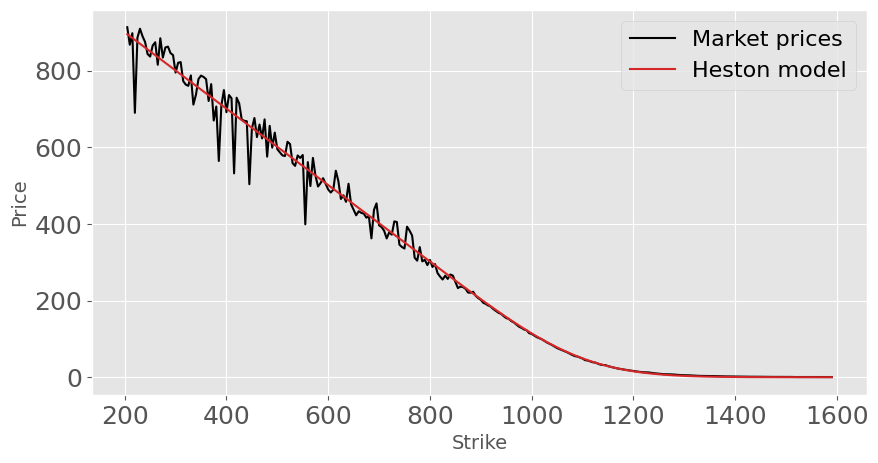

In [26]:
vis.plot_prices(K, marketPrice, option_heston_cos, 'Heston')

### Bates model

In [27]:
calibratedParms = errf.calibrationBates(type_option, K, marketPrice, s0, T, tau, N=2**8, L=8, r=r)

kv_bates = calibratedParms.get('k')
gamma_v_bates = calibratedParms.get('gamma')
vbar_bates = calibratedParms.get('vb')
v0_bates = calibratedParms.get('v0')
rho_bates = calibratedParms.get('rho')
xi_bates = calibratedParms.get('xi')
muJ_bates = calibratedParms.get('muJ')
sigmaJ_bates = calibratedParms.get('sigmaJ')

errorFinal_bates = calibratedParms.get('ErrorFinal') 

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 927.111180500656
        x: [ 4.409e-02  1.003e-04  2.447e+00  3.000e-01 -8.250e-02
             1.000e-04 -1.000e+01  1.000e-04]
      nit: 2
      jac: [ 1.077e+03  1.061e+03  1.485e-01  1.295e+02  6.742e+02
            -2.612e+01  1.137e-05 -6.821e-05]
     nfev: 144
     njev: 16
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>


In [28]:
np.sqrt(errorFinal_bates)

30.448500463908825

In [29]:
L = 8
N = 2**8

cf = chf.ChFBatesModel(r, tau, kv_bates, gamma_v_bates, vbar_bates, v0_bates, rho_bates, xi_bates, muJ_bates, sigmaJ_bates)
valCOS_Bates = exm.CallPutOptionPriceCOS(cf, type_option, s0, r, T, K, N, L)

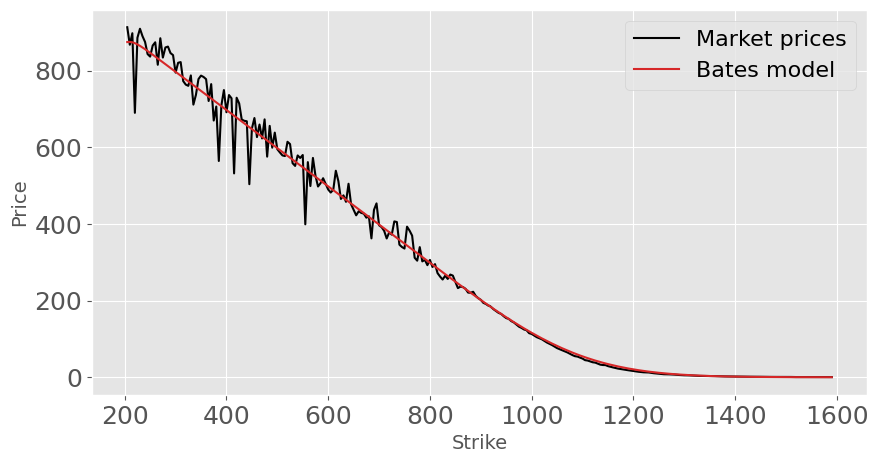

In [30]:
vis.plot_prices(K, marketPrice, valCOS_Bates, 'Bates')

### Heston Hull-White model (stochastic interest rate)

Optimal parameters for H1-HW are: gamma = 1.000, vBar = 0.050, Rxv = -0.700, v0 = 0.050
Final error for H1HW = nan


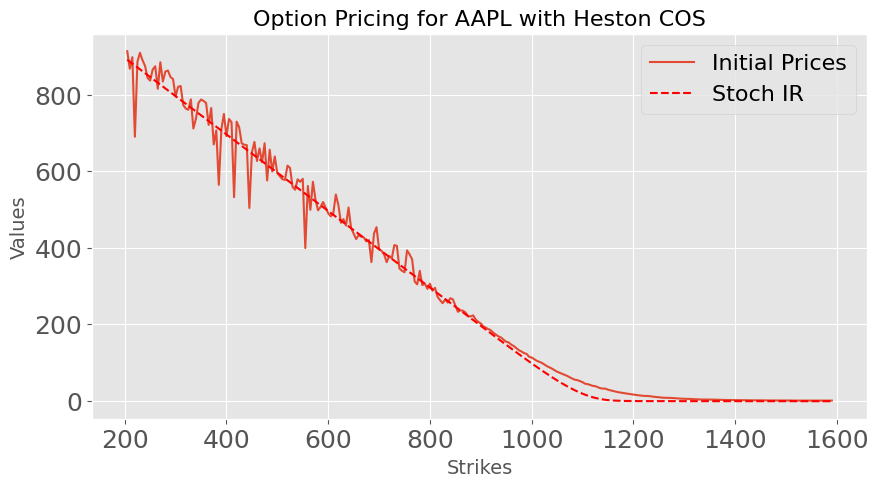

In [31]:
CP = hhw.OptionType.CALL
valCOS_H1HW, P0T, lambd_HW, eta_HW, T, kappa_HW, gamma_HW, vBar_HW, v0_HW, Rxv_HW, Rxr_HW = hhw.heston_HW(s0, marketPrice, tau, t0, K, CP)

### Generalized Bates model with stochastic interest rate and correlation by DCL process 

In [32]:
def neg_price_corr(value):
    value = value.T[0]
        
    if np.any(value < 0):
        value[np.where(value < 0)[0]] = [np.min(value[np.where(value > 0)[0]])]*(len(np.where(value < 0)[0]))

    value = value.reshape(-1, 1)
    
    return value

In [33]:
calibratedParms = errf.calibrationBates_SIR_SC_DCL(type_option, K, marketPrice, s0, T, tau, N=2**8, L=10, method='L-BFGS-B')

kv = calibratedParms.get('k')
gamma_v = calibratedParms.get('gamma')
vbar = calibratedParms.get('vb')
gamma_r = calibratedParms.get('gammar')
mur = calibratedParms.get('mur')
rho4 = calibratedParms.get('rho4')
rho5 = calibratedParms.get('rho5')
v0 = calibratedParms.get('v0')
kr = calibratedParms.get('kr')
theta = calibratedParms.get('theta')
rho0 = calibratedParms.get('rho0')
r0 = calibratedParms.get('r0')
muJ = calibratedParms.get('muJ')
sigmaJ = calibratedParms.get('sigmaJ')
xi = calibratedParms.get('xi')
delta = calibratedParms.get('delta')

errorFinal = calibratedParms.get('ErrorFinal') 

L = 8
N = 2**8

cf = chf.ChFBates_StochIR_StochCor_DCL(tau, T, kv, gamma_v, vbar, kr, gamma_r, mur, theta, delta, rho4, rho5, xi, muJ, sigmaJ, v0, r0, rho0, x0)
valCOS_DCL = exm.optionPriceCOSMthd_StochIR(cf, type_option, s0, T, K, N, L)

list_params = np.array([v0, kv, gamma_v, vbar, kr, gamma_r, mur, theta, delta, rho4, rho5, muJ, sigmaJ, r0, rho0, xi])
pd.DataFrame(list_params.reshape(-1, 1), index=['v0', 'kv', 'gamma_v', 'vbar', 'kr', 'gamma_r', 'mur', 'theta', 'delta', 'rho4', 'rho5', 'muJ', 'sigmaJ', 'r0', 'rho0', 'xi'],\
                                        columns=['Parameters'])

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 922.9937600759732
        x: [ 8.109e-01  1.051e-02 ...  1.000e-02 -9.583e-01]
      nit: 8
      jac: [-3.988e-02  1.827e+00 ...  1.113e+01 -2.141e-02]
     nfev: 170
     njev: 10
 hess_inv: <16x16 LbfgsInvHessProduct with dtype=float64>


,Parameters
v0,0.198737
kv,0.810909
gamma_v,0.010509
vbar,1.385992
kr,1.969654
gamma_r,0.758377
mur,1.966059
theta,1.992611
delta,1.000202
rho4,0.100022


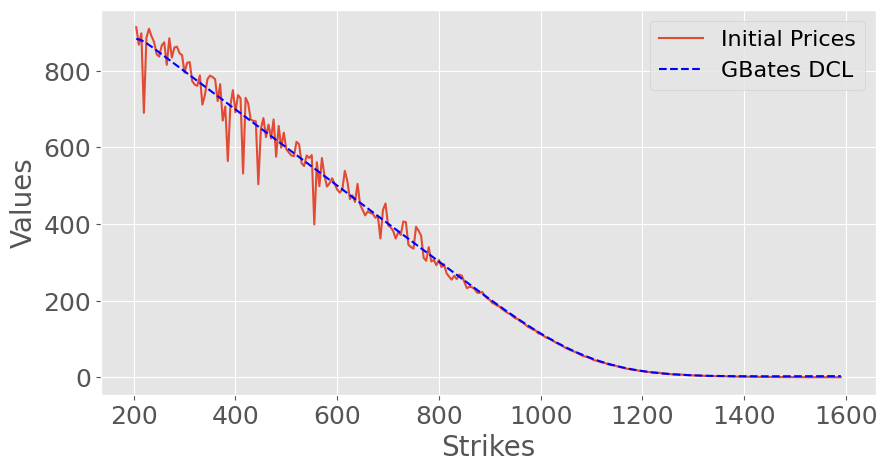

In [34]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(K, marketPrice, label='Initial Prices')
plt.plot(K, valCOS_DCL, '--', color='blue', label='GBates DCL')
# plt.plot(K, valCOS, '.', color='red', label='BSCSIR')
        
# plt.title('Option Pricing for AAPL with Bates Stoch. Corr. DCL Stoch. IR ', fontsize=16)
plt.xlabel('Strikes')
plt.ylabel('Values')
plt.legend()
plt.show()

In [35]:
np.sqrt(errorFinal)

30.380812366952487

### Generalized Bates model with stochastic interest rate and correlation by OU process 

In [36]:
calibratedParms = errf.calibrationBates_SIR_SC_OU(type_option, K, marketPrice, s0, T, tau, N=2**8, L=8, method='L-BFGS-B')

kv_ou = calibratedParms.get('k')
gamma_v_ou = calibratedParms.get('gamma')
vbar_ou = calibratedParms.get('vb')
gamma_r_ou = calibratedParms.get('gammar')
mur_ou = calibratedParms.get('mur')
rho4_ou = calibratedParms.get('rho4')
rho5_ou = calibratedParms.get('rho5')
v0_ou = calibratedParms.get('v0')
kr_ou = calibratedParms.get('kr')
theta_ou = calibratedParms.get('theta')
rho0_ou = calibratedParms.get('rho0')
r0_ou = calibratedParms.get('r0')
muJ_ou = calibratedParms.get('muJ')
sigmaJ_ou = calibratedParms.get('sigmaJ')
xi_ou = calibratedParms.get('xi')
delta_ou = calibratedParms.get('delta')
mu_rho_ou = calibratedParms.get('mu_rho')
sigma_rho_ou = calibratedParms.get('sigma_rho')

errorFinal_ou = calibratedParms.get('ErrorFinal') 


L = 8
N = 2**8

cf = chf.ChFBates_StochIR_StochCor_OU(tau, T, kv_ou, gamma_v_ou, vbar_ou, kr_ou, gamma_r_ou, mur_ou, theta_ou, delta_ou, rho4_ou, rho5_ou, xi_ou, muJ_ou,
                                    sigmaJ_ou, v0_ou, r0_ou, rho0_ou, x0, mu_rho_ou, sigma_rho_ou)
valCOS_OU = exm.optionPriceCOSMthd_StochIR(cf, type_option, s0, T, K, N, L)

list_params = np.array([v0_ou, kv_ou, gamma_v_ou, vbar_ou, kr_ou, gamma_r_ou, mur_ou, theta_ou, delta_ou, rho4_ou, rho5_ou, muJ_ou,
                        sigmaJ_ou, r0_ou, rho0_ou, xi_ou, mu_rho_ou, sigma_rho_ou])
pd.DataFrame(list_params.reshape(-1, 1), index=['v0', 'kv', 'gamma_v', 'vbar', 'kr', 'gamma_r', 'mur', 'theta', 'delta', 'rho4', 'rho5',
                                                'muJ', 'sigmaJ', 'r0', 'rho0', 'xi', 'mu_rho', 'sigma_rho'],\
                                        columns=['Parameters'])

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 922.8623504332616
        x: [ 7.405e-02  1.000e-04 ...  9.991e-02  3.000e-01]
      nit: 6
      jac: [-5.676e-02  4.851e+00 ...  5.684e-05  6.821e-05]
     nfev: 152
     njev: 8
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>


,Parameters
v0,0.243081
kv,0.074053
gamma_v,0.000100
vbar,1.461839
kr,1.952067
gamma_r,1.000000
mur,1.948266
theta,2.024058
delta,1.000000
rho4,0.099911


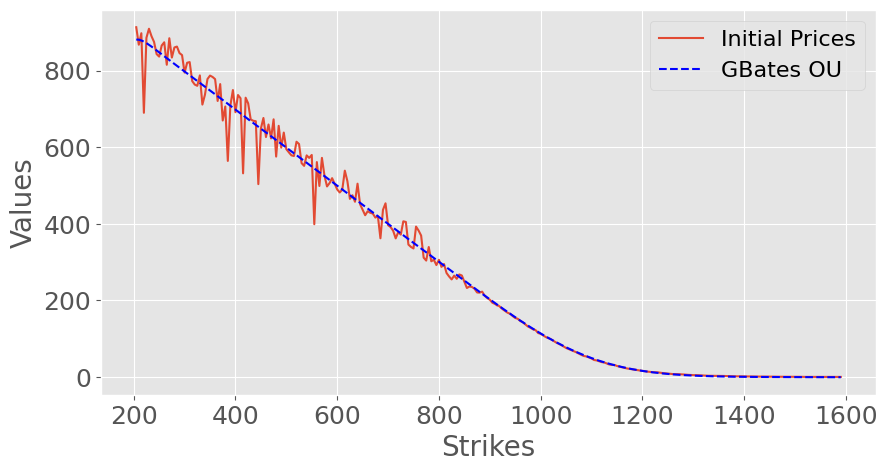

In [37]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(K, marketPrice, label='Initial Prices')
plt.plot(K, valCOS_OU, '--', color='blue', label='GBates OU')
# plt.plot(K, valCOS, '.', color='red', label='BSCSIR')
        
# plt.title('Option Pricing for AAPL with Bates Stoch. Corr. DCL Stoch. IR ', fontsize=16)
plt.xlabel('Strikes')
plt.ylabel('Values')
plt.legend()
plt.show()

In [38]:
np.sqrt(errorFinal_ou)

30.37864958212036

## Implied Volatility

In [39]:
def ImpliedVolatilityBlack76(marketPrice, K, r0):
    sigmaGrid = np.linspace(0.01, 2, 1000)
    optPriceGrid = exm.BS_Call_Put_Option_Price(type_option, s0, K, sigmaGrid, T, r0)
    sigmaInitial = np.interp(marketPrice, optPriceGrid, sigmaGrid)
    
    # Use determined input for the local-search (final tuning)
    func = lambda sigma: np.power(exm.BS_Call_Put_Option_Price(type_option, s0, K, sigma, T, r0) - marketPrice, 1.0)
    impliedVol = newton(func, sigmaInitial, tol=1e-10, maxiter=200, disp=False)

    return impliedVol

In [40]:
r_basic = 0.055

In [41]:
K = K.values

In [42]:
# K = K[1:]
# marketPrice = marketPrice[1:]

In [43]:
def quantile_corr(price, q=0.01):
    # idx = np.where(price > np.quantile(price, q))[0]
    idx = np.where(price > q)[0]
    return price[idx], idx

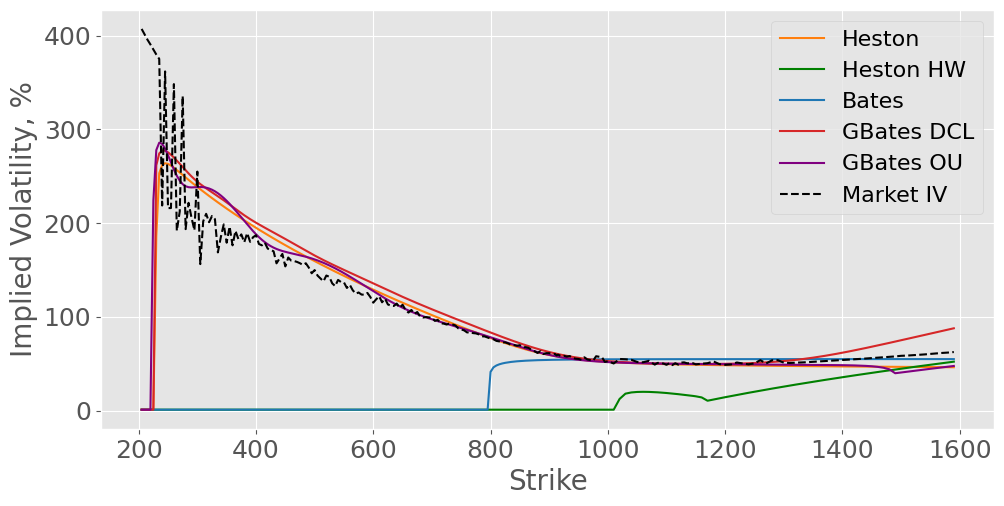

In [44]:
plt.subplots(figsize=(10, 5), dpi=100)

# cf = chf.ChFBates_StochIR_StochCor(tau, T, k_b, gamma, vb_b, kr_b, gammar_b, mur_b, krho_b, murho_b,\
#                                    sigmarho_b, rho4_b, rho5_b, xip_b, muJ_b, sigmaJ_b, v0_b, r0_b, rho0_b)
# valCOS = exm.optionPriceCOSMthd_StochIR(cf, type_option, s0, T, K, N, L)

# IV =np.zeros([len(K),1])
# for idx in range(0,len(K)):
#     IV[idx] = ImpliedVolatilityBlack76(valCOS[idx], K[idx])

cf = chf.ChFBatesModel(r, tau, kv_bates, gamma_v_bates, vbar_bates, v0_bates, rho_bates, xi_bates, muJ_bates, sigmaJ_bates)
bates_cos = neg_price_corr(exm.CallPutOptionPriceCOS(cf, type_option, s0, r, T, K, N, L))[:,0]

IV_bates =np.zeros([len(K),1])
for idx in range(0,len(K)):
    IV_bates[idx] = ImpliedVolatilityBlack76(bates_cos[idx], K[idx], r_basic)
IV_bates, idx_bates = quantile_corr(IV_bates)
    
cf_h = chf.ChFHestonModel(r_h, T, kappa_h, gamma_h, vbar_h, v0_h, rho_h)
option_heston_cos = neg_price_corr(exm.CallPutOptionPriceCOS(cf_h, type_option, s0, r_h, T, K, N, L)).T[0]
# option_heston_cos = BS_Call_Put_Option_Price('put', s0, K, gamma_h, T, r_h)

IV_heston =np.zeros([len(K),1])
for idx in range(0,len(K)):
    IV_heston[idx] = ImpliedVolatilityBlack76(option_heston_cos[idx], K[idx], r_basic)
IV_heston, idx_heston = quantile_corr(IV_heston)

# IV_BS = np.zeros([len(K),1])
# for idx in range(0,len(K)):
#     IV_BS[idx] = ImpliedVolatilityBlack76(marketPrice[idx], K[idx], r_basic)
# idx_BS = np.where(IV_BS > np.quantile(IV_BS, 0.01))[0]
# IV_BS = IV_BS[idx_BS]

# IV_BS = []
# for idx in range(0,len(K)):
#     IV_BS.append(ImpliedVolatilityBlack76(marketPrice[idx], K[idx], r_basic))
    
# IV_BS = np.array(IV_BS).T
# IV_BS = np.array([0.3]*len(K))

    
cf_dcl = chf.ChFBates_StochIR_StochCor_DCL(tau, T, kv, gamma_v, vbar, kr, gamma_r, mur, theta, delta, rho4, rho5, xi, muJ, sigmaJ, v0, r0, rho0, x0)
valCOS_DCL = neg_price_corr(exm.optionPriceCOSMthd_StochIR(cf_dcl, type_option, s0, T, K, N, L)).T[0]
IV_DCL = np.zeros([len(K),1])
for idx in range(0,len(K)):
    IV_DCL[idx] = ImpliedVolatilityBlack76(valCOS_DCL[idx], K[idx], r_basic)
IV_DCL, idx_DCL = quantile_corr(IV_DCL)

cf_ou = chf.ChFBates_StochIR_StochCor_OU(tau, T, kv_ou, gamma_v_ou, vbar_ou, kr_ou, gamma_r_ou, mur_ou, theta_ou, delta_ou, rho4_ou, rho5_ou, xi_ou, muJ_ou, sigmaJ_ou, v0_ou, r0_ou, rho0_ou, x0, mu_rho_ou, sigma_rho_ou)
valCOS_OU = neg_price_corr(exm.optionPriceCOSMthd_StochIR(cf_ou, type_option, s0, T, K, N, L)).T[0]
IV_OU = np.zeros([len(K),1])
for idx in range(0,len(K)):
    IV_OU[idx] = ImpliedVolatilityBlack76(valCOS_OU[idx], K[idx], r_basic)
IV_OU, idx_OU = quantile_corr(IV_OU)

cf2 = hhw.ChFH1HWModel(P0T, lambd_HW, eta_HW, T, kappa_HW, gamma_HW, vBar_HW, v0_HW, Rxv_HW, Rxr_HW)
valCOS_H1HW = neg_price_corr(hhw.CallPutOptionPriceCOSMthd_StochIR(cf2, CP, s0, T, K, N, L,P0T(T)))
IV_HW = np.zeros([len(K),1])
for idx in range(0,len(K)):
    IV_HW[idx] = ImpliedVolatilityBlack76(valCOS_H1HW[idx], K[idx], r_basic)
IV_HW, idx_HW = quantile_corr(IV_HW)

# plt.plot(K, IV_BS*100.0, c='black', label=f'Market')
plt.plot(K[idx_heston], IV_heston*100.0, c='tab:orange', label=f'Heston')
plt.plot(K[idx_HW], IV_HW*100.0, c='green', label=f'Heston HW')
plt.plot(K[idx_bates], IV_bates*100.0, c='tab:blue', label=f'Bates')
plt.plot(K[idx_DCL], IV_DCL*100.0, c='tab:red', label=f'GBates DCL')
plt.plot(K[idx_OU], IV_OU*100.0, c='purple', label=f'GBates OU')
# plt.plot(K, IV_heston*100.0, c='tab:orange', label=f'Heston')
# plt.plot(K, IV_HW*100.0, c='green', label=f'Heston HW')
# plt.plot(K, IV_bates*100.0, c='tab:blue', label=f'Bates')
# plt.plot(K, IV_DCL*100.0, c='tab:red', label=f'GBates DCL')
# plt.plot(K, IV_OU*100.0, c='purple', label=f'GBates OU')


plt.plot(K, option_IV*100, '--', color='black', label='Market IV')
# plt.plot(K[idx_BS], IV_BS)

plt.legend()
plt.xlabel('Strike')
plt.ylabel('Implied Volatility, %')
# plt.title('Smile Effect of Implied Volatility')

plt.tight_layout(pad=0.5)
# plt.savefig('Images/implied_volatility_NVDA_with_market_long.pdf', dpi=300)
plt.show()

In [45]:
def mse_iv_calc(init_iv, model_iv, model_strike_idx):
    return np.sqrt(np.mean((init_iv.iloc[model_strike_idx].values - model_iv.reshape(1, -1)[0])**2))

In [46]:
def mse_iv_calc_all(init_iv, models_iv: list, model_strike_idx: list) -> list:
    return list(map(lambda x, y: mse_iv_calc(init_iv, x, y), models_iv, model_strike_idx))

In [47]:
pd.DataFrame(mse_iv_calc_all(option_IV, [IV_bates, IV_heston, IV_HW, IV_DCL, IV_OU], [idx_bates, idx_heston, idx_HW, idx_DCL, idx_OU]), 
             columns=['RMSE Implied volatility'], index=['Bates','Heston', 'Heston HW', 'GBates DCL', 'GBates OU'])

,RMSE Implied volatility
Bates,1.296515
Heston,0.630495
Heston HW,1.330915
GBates DCL,0.629217
GBates OU,0.575531


## Measure transformation

In [48]:
zcb0 = chf.zcb_curve(tau, kr, mur, gamma_r, r0)
zcb0

0.9944567725475373

#uncomment to measure time

In [49]:
%%time  
numberPaths = 20000
N = 1000

time, S, M = mcm.bates_SC_SIR_DCL_AES(numberPaths, N, s0, v0, T, kv, gamma_v, vbar, kr, gamma_r, mur, theta, delta, rho4, rho5,
                    xi, muJ, sigmaJ, r0, rho0)

CPU times: user 5.88 s, sys: 450 ms, total: 6.33 s
Wall time: 6.48 s


In [50]:
%%time
numberPaths = 20000
N = 1000

time, S_Tm = mcm.bates_SC_SIR_DCL_AES_Tm(numberPaths, N, s0, v0, T, kv, gamma_v, vbar, kr, gamma_r, mur, theta, delta, rho4, rho5,
                    xi, muJ, sigmaJ, r0, rho0)

CPU times: user 5.31 s, sys: 832 ms, total: 6.15 s
Wall time: 6.58 s


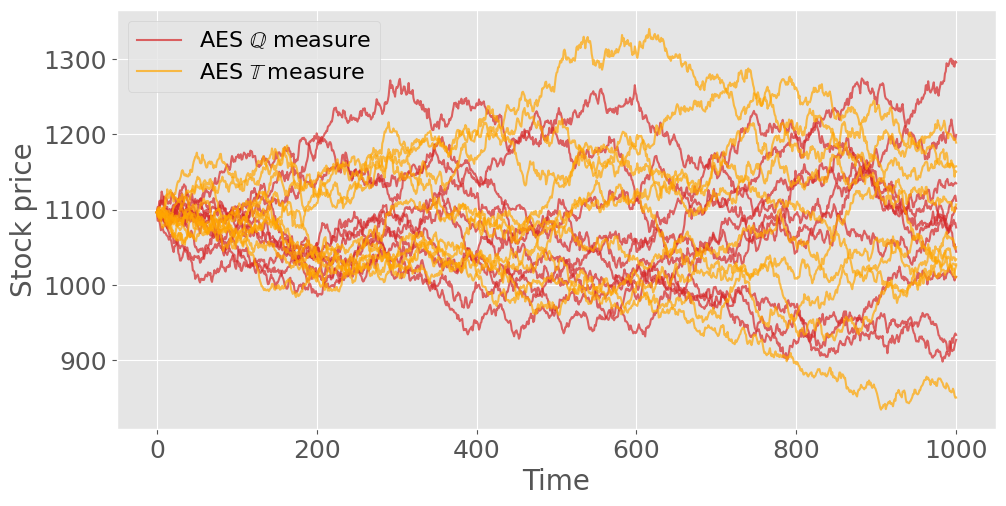

In [51]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)  
vis.plotCollection(ax, S[:10].T, color='tab:red', label='AES $\mathbb{Q}$ measure', alpha=0.7)
vis.plotCollection(ax, S_Tm[:10].T, color='orange', label='AES $\mathbb{T}$ measure', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Stock price')

plt.tight_layout(pad=0.5)
# plt.savefig('Images/Tmeasure_realizations.pdf', dpi=300)
plt.show()

In [52]:
option_bates_stoch_AES = mcm.optionPriceMC_Stoch(type_option, S[:, -1], K, T, M[:, -1])
option_bates_stoch_AES_Tm = mcm.optionPriceMC_Stoch_Tm(type_option, S_Tm[:, -1], K, T, zcb0)

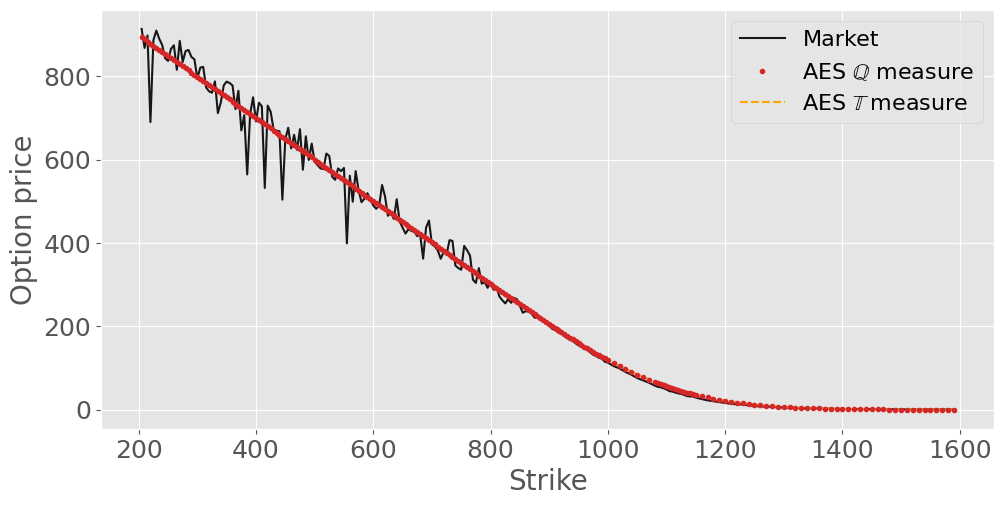

In [53]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(K, marketPrice, color='black', label='Market', alpha=0.9)
# plt.plot(option_strikes, valCOS, color='green', label='COS Method')
plt.plot(K, option_bates_stoch_AES, '.',color='tab:red', label='AES $\mathbb{Q}$ measure', zorder=3)
plt.plot(K, option_bates_stoch_AES_Tm, '--',color='orange', label='AES $\mathbb{T}$ measure')
        
# plt.title('Option Pricing BSCSIR', fontsize=16)
plt.xlabel('Strike')
plt.ylabel('Option price')
plt.legend()


plt.tight_layout(pad=0.5)
# plt.savefig('Images/Tmeasure.pdf', dpi=300)
plt.show()

In [54]:
np.mean((1/M[:, -1]))

0.9944432480857367

In [55]:
zcb0

0.9944567725475373

In [56]:
# dt = 0.0001 
# P0T = lambda T: np.exp(0.0012*T+0.0007) 
# f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2.0*dt)
# f0T(0.00001)

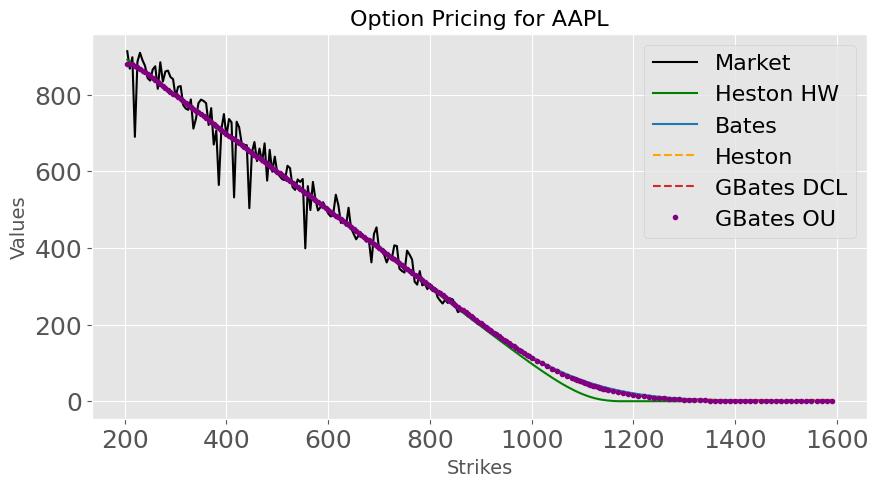

In [57]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(K, marketPrice, color='black', label='Market')
plt.plot(K, valCOS_H1HW, color='green', label='Heston HW')
plt.plot(K, valCOS_Bates, color='tab:blue', label='Bates')
plt.plot(K, option_heston_cos, '--', color='orange', label='Heston')
plt.plot(K, valCOS_DCL, '--', color='tab:red', label='GBates DCL')
plt.plot(K, valCOS_OU, '.', color='purple', label='GBates OU')

plt.title('Option Pricing for AAPL', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()